In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import math
import os

In [2]:
class PGMImage:
    def __init__(self, file_path=None):
        self.magic_number = None
        self.width = 0
        self.height = 0
        self.maxval = 0
        self.pixels = []

        if file_path:
            self.mypgmread(file_path)

    def mypgmread(self, file_path):
        with open(file_path, 'rb') as file:
            self.magic_number = file.readline().strip().decode('ascii')

            line = file.readline().strip()
            while line.startswith(b'#'): 
                line = file.readline().strip()

            self.width, self.height = map(int, line.split())
            self.maxval = int(file.readline().strip())
            data = file.read()
            self.pixels = list(data)

    def modify_pixels(self, row_start, row_end, new_value):
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        pixels_2d[row_start:row_end, :] = new_value
        self.pixels = pixels_2d.flatten().tolist()

    def mypgmwrite(self, filename):
        pixel_array = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))

        with open(filename, 'wb') as file:
            file.write(f"{self.magic_number}\n".encode())
            file.write(f"{self.width} {self.height}\n".encode())
            file.write(f"{self.maxval}\n".encode())
            pixel_array.tofile(file)

####################################################################################################################################################
############################## LAB-01 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    def myImageLinearScale(self, pixel_array):  # pixel değerlerini normalize etme fonksiyonu
        min_pixel_value = np.min(self.pixels)  # pixel değerinin minimumunu belirler
        max_pixel_value = np.max(self.pixels)  # pixel değerinin maksimumunu belirler

        # Check if max and min are the same (to avoid division by zero)
        if max_pixel_value == min_pixel_value:
            self.pixels = [0] * len(self.pixels)  # All pixels are the same, set everything to 0
        else:
            # Pixels listesindeki her değeri min/max değerleri arasında normalize eder ve 0-255 aralığına getirir
            self.pixels = [int(self.maxval * (pixel - min_pixel_value) / (max_pixel_value - min_pixel_value))
                        for pixel in self.pixels]

        return self.pixels

    def myImageNegative(self): # görüntünün negatifini alma fonksiyonu
        # her bir pixel değerini max değerden çıkarır böylelikle bütü değerler ters çevirilmiş olur
        self.pixels = [self.maxval - pixel for pixel in self.pixels] 
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir

    def myImageLogTransform(self): # log transformu fonksiyonu
        # her bir pixel değeri için ders kitabındaki logaritma formül uygulanmıştır.
        self.pixels = [np.log(1 + pixel) for pixel in self.pixels]
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir
        
        
    def myImageGammaTransform(self, gamma): # gama transformu fonksiyonu girdi olarak gamanın değeri verilebilir
        # yine her bir pixel için ders kitbında verilen Power-Laz(gama) formülü uygulanır
        self.pixels = [int(self.maxval * (pixel / self.maxval) ** gamma) for pixel in self.pixels]
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir


    def myImageCorrelation(self, kernel): # kernel dışarıdan verilir
        k_height, k_width = kernel.shape # kernelin yükseklik ve genişliği .shape ile elde edilir
        g = np.zeros((self.height, self.width), dtype=np.float32) # çıkış değerini tutmak için imagein boyutlarında 0'lardan oluşan liste oluşturulur
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width)) # orjinal imagein pixelleri boyutlandırlır
        
        for x in range(0 , self.height): # orjinal görüntünün her pixelinde işlem yapmak için for döngüsü kurulur
            for y in range(0, self.width):
                for s in range(-k_height//2, k_height//2): # kernelin her bir değerinde işlem yapmak için for döngüleri kurulur
                    for t in range(-k_width//2, k_width//2):
                        if x+s >= 0 and x+s < self.height and y+t >= 0 and y+t < self.width: # sınır noktalar tanımlanır
                                g[x][y] += kernel[s][t] * pixels_2d[x+s][y+t] # çıkış değerine kernelin ile orjinal görüntünün her bir pixel değeriyle çarpılıp toplanmış değeri atanır
        
        #self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir
        return g # çıkış değeri iki boyutlu olarak döndürülür

    def myImageMedianFilter(self, k_height, k_width):
        g = np.zeros((self.height, self.width), dtype=np.float32)
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        for x in range(0 , self.height):
            for y in range(0, self.width):
                kernel_array = [] # kernel in içindeki her bir değeri tutmak için oluşturulur
                for s in range(-k_height//2, k_height//2): # kernelin her bir değerini döner
                    for t in range(-k_width//2, k_width//2):
                        if x+s >= 0 and x+s < self.height and y+t >= 0 and y+t < self.width: 
                            kernel_array.append(pixels_2d[x+s][y+t]) # komşu pixelleri listenin içinde tutar
                g[x][y] = np.median(kernel_array) # komşu pixellerin medianını alır ve orjinal görüntünün o an işlenen pixeline yazar
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir

        return g  # çıkış değeri iki boyutlu olarak döndürülür
        


####################################################################################################################################################
############################## LAB-02 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    def myGaussianKernel(self, size, sigma): # gauss kernelini oluşturmak için kullanılan fonksiyon
        kernel = np.zeros((size, size), dtype=np.float32) # boş kernel oluşturulur
        center = size // 2 # merkez belirlenir
        
        for x in range(size):
            for y in range(size): 
                x_distance = (x - center) ** 2 # gauss simetrik olduğundan sağ ve sol içinde aynı uzaklık kullanılır
                y_distance = (y - center) ** 2
                kernel[x, y] = np.exp(-(x_distance + y_distance) / (2 * sigma ** 2)) # boş kernelin içine gauss denkleminden elde edilen veriler girilir
        
        kernel /= np.sum(kernel) # kernelin içindeki değerler toplama bölünür scale etmek için
        
        return kernel

    def myHistogramEqualization(self): # histogram eşitleme fonksiyonu
        pixel = np.zeros((self.height, self.width), dtype=np.float32) # boş pixel değerleri  oluşturulur.

        hist, _ = np.histogram(self.pixels, 256, [0, 256]) # pixels değerlerine göre historam oluşturulur.
        
        cdf = np.zeros(256, dtype=np.float32) # kümülatif dağılım için boş dizi oluşturulur.
        cdf[0] = hist[0] # ilk histogram değeri cdf e atanır

        for i in range(1, 256):
            cdf[i] = hist[i] + cdf[i - 1] # önceki cdf değerine histogram değeri eklenir

        cdf_normalized = cdf / cdf[-1]  # cdf normalize edilir bütün değerler 0-1 aralığına sıkıştırılır

        for i in range(256): # her bir yoğunluk seviyesine yeni bir piksel değeri atanır
            pixel_value = int(cdf_normalized[i] * 255)
            cdf[i] = pixel_value

        for i in range(len(self.pixels)): # Görüntüdeki her piksel değeri, yeni hesaplanan cdf değerine göre değiştirilir.
            self.pixels[i] = cdf[self.pixels[i]]

        return self.pixels, cdf_normalized  






LAPLACİAN MASKING

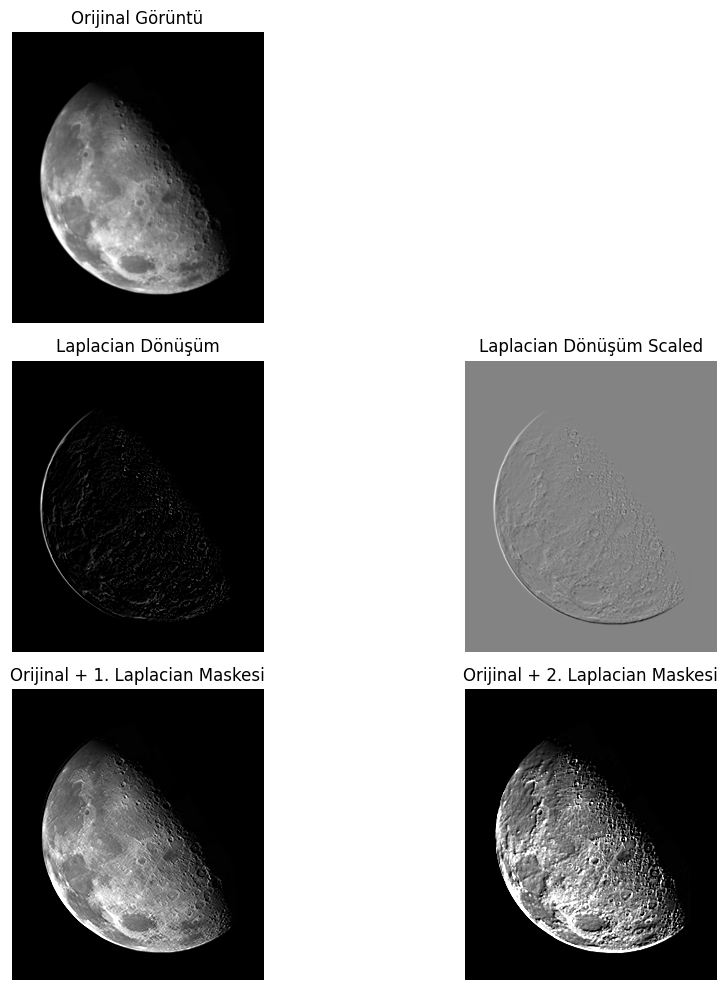

In [15]:

pgm_image = PGMImage('Fig0338(a)(blurry_moon).pgm')
original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

# LAPLACİAN 1
laplacian_kernel = np.array([[0, 1, 0], 
                             [1, -4, 1], 
                             [0, 1, 0]], dtype=np.float32)
    
laplacian_image = pgm_image.myImageCorrelation(laplacian_kernel)

# LAPLACİAN with scailing
pgm_image.pixels = laplacian_image.flatten().tolist()
laplacian_image_scailed = pgm_image.myImageLinearScale(pgm_image.pixels)
laplacian_scailed = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

# LAPLACİAN filtrenin uygulanması

# Orijinal görüntü ile Laplacian maskesini ekleme
pgm_image = PGMImage('Fig0338(a)(blurry_moon).pgm')
laplacian_added_image = original_image +((-1) * laplacian_image)


# LAPLACİAN 2
laplacian_kernel_2 = np.array([[1, 1, 1], 
                              [1, -8, 1], 
                              [1, 1, 1]], dtype=np.float32)


pgm_image = PGMImage('Fig0338(a)(blurry_moon).pgm')
laplacian_image_2 = pgm_image.myImageCorrelation(laplacian_kernel_2)

# 2. maskenin uygulanması
laplacian_added_image_2 = original_image + ((-1) * laplacian_image_2)


plt.figure(figsize=(10, 10))

# Orijinal görüntü
plt.subplot(3, 2, 1)
plt.title("Orijinal Görüntü")
plt.axis('off')
plt.imshow(original_image, cmap='gray')

plt.subplot(3, 2, 3)
plt.title("Laplacian Dönüşüm")
plt.axis('off')
plt.imshow(laplacian_image, cmap='gray', vmin= 0 , vmax=255)

plt.subplot(3, 2, 4)
plt.title("Laplacian Dönüşüm Scaled")
plt.axis('off')
plt.imshow(laplacian_scailed, cmap='gray')

# Laplacian maskesi eklenmiş orijinal görüntü
plt.subplot(3, 2, 5)
plt.title("Orijinal + 1. Laplacian Maskesi")
plt.axis('off')
plt.imshow(laplacian_added_image, cmap='gray', vmin= 0 , vmax=255)

# Laplacian maskesi eklenmiş orijinal görüntü
plt.subplot(3, 2, 6)
plt.title("Orijinal + 2. Laplacian Maskesi")
plt.axis('off')
plt.imshow(laplacian_added_image_2 , cmap='gray', vmin= 0 , vmax=255)


plt.tight_layout()
plt.show()


UNSHARP MASKİNG

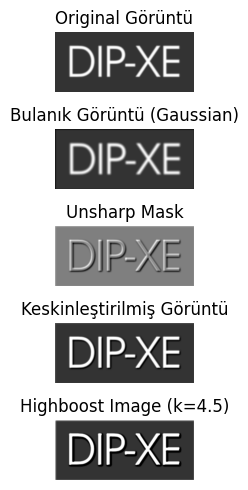

In [22]:
# 1. Blur the original image.
# 2. Subtract the blurred image from the original (the resulting difference is called the mask.)
# 3. Add the mask to the original.
import numpy as np
import matplotlib.pyplot as plt

pgm_image = PGMImage('Fig0340(a)(dipxe_text).pgm')
original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

# Gaussian kernel kullanaral orginal görüntüyü bulanıklaştır 
gaussian_kernel = pgm_image.myGaussianKernel(5, 3)   # gauss kernelini oluştur

blurred_image = pgm_image.myImageCorrelation(gaussian_kernel) # Gaussian kernel kullanaral orginal görüntüyü bulanıklaştır 
blurred_image = np.array(blurred_image, dtype=np.float32).reshape((pgm_image.height, pgm_image.width)) # 2d hale getir

# unsharp maskeyi elde etmek için bulanık görüntüyü orjinaliinden çıkart
unsharp_mask = original_image.astype(np.float32) - blurred_image

# unsharp maskesini ölçeklendir
pgm_image.pixels = unsharp_mask.flatten().tolist()
unsharp_mask_scaled_1d = pgm_image.myImageLinearScale(pgm_image.pixels)
unsharp_mask_scaled = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

# keskinleştirmek için unsharp maskeyi orjinal görüntüye ekle
sharpened_image = original_image.astype(np.float32) + unsharp_mask

sharpened_image = np.clip(sharpened_image, 0, 255)

# keşkinleştirilmiş görüntüyü ölçeklendir
pgm_image.pixels = sharpened_image.flatten().tolist()
sharpened_image_scaled_1d = pgm_image.myImageLinearScale(pgm_image.pixels)
sharpened_image_scaled = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

# 4. Highboost Filtering
k = 4.5  # verilen k değerini tanımla
weighted_mask = k * unsharp_mask # k değeri unsharp maskenin ağırlığı olarak verilmiş bunlar çarpılarak weighted mask elde edilir
highboost_image = original_image.astype(np.float32) + weighted_mask # weighted_mask ın orjinal görüntiye eklenmesi de highboost image ı verir
highboost_image = np.clip(highboost_image, 0, 255)

# highboost imagei ölçeklendir
pgm_image.pixels = highboost_image.flatten().tolist()
highboost_image_scaled_1d = pgm_image.myImageLinearScale(pgm_image.pixels)
highboost_image_scaled = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))

plt.figure(figsize=(25, 5))  

plt.subplot(5, 1, 1)  
plt.title("Original Görüntü")
plt.axis('off')
plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)

plt.subplot(5, 1, 2)  
plt.title("Bulanık Görüntü (Gaussian)")
plt.axis('off')
plt.imshow(blurred_image, cmap='gray', vmin=0, vmax=255)

plt.subplot(5, 1, 3)  
plt.title("Unsharp Mask")
plt.axis('off')
plt.imshow(unsharp_mask_scaled, cmap='gray')

plt.subplot(5, 1, 4) 
plt.title("Keskinleştirilmiş Görüntü")
plt.axis('off')
plt.imshow(sharpened_image_scaled, cmap='gray')

plt.subplot(5, 1, 5)  
plt.title("Highboost Image (k=4.5)")
plt.axis('off')
plt.imshow(highboost_image_scaled, cmap='gray')

plt.tight_layout()
plt.show()

HISTOGRAM EQUALİZATİON

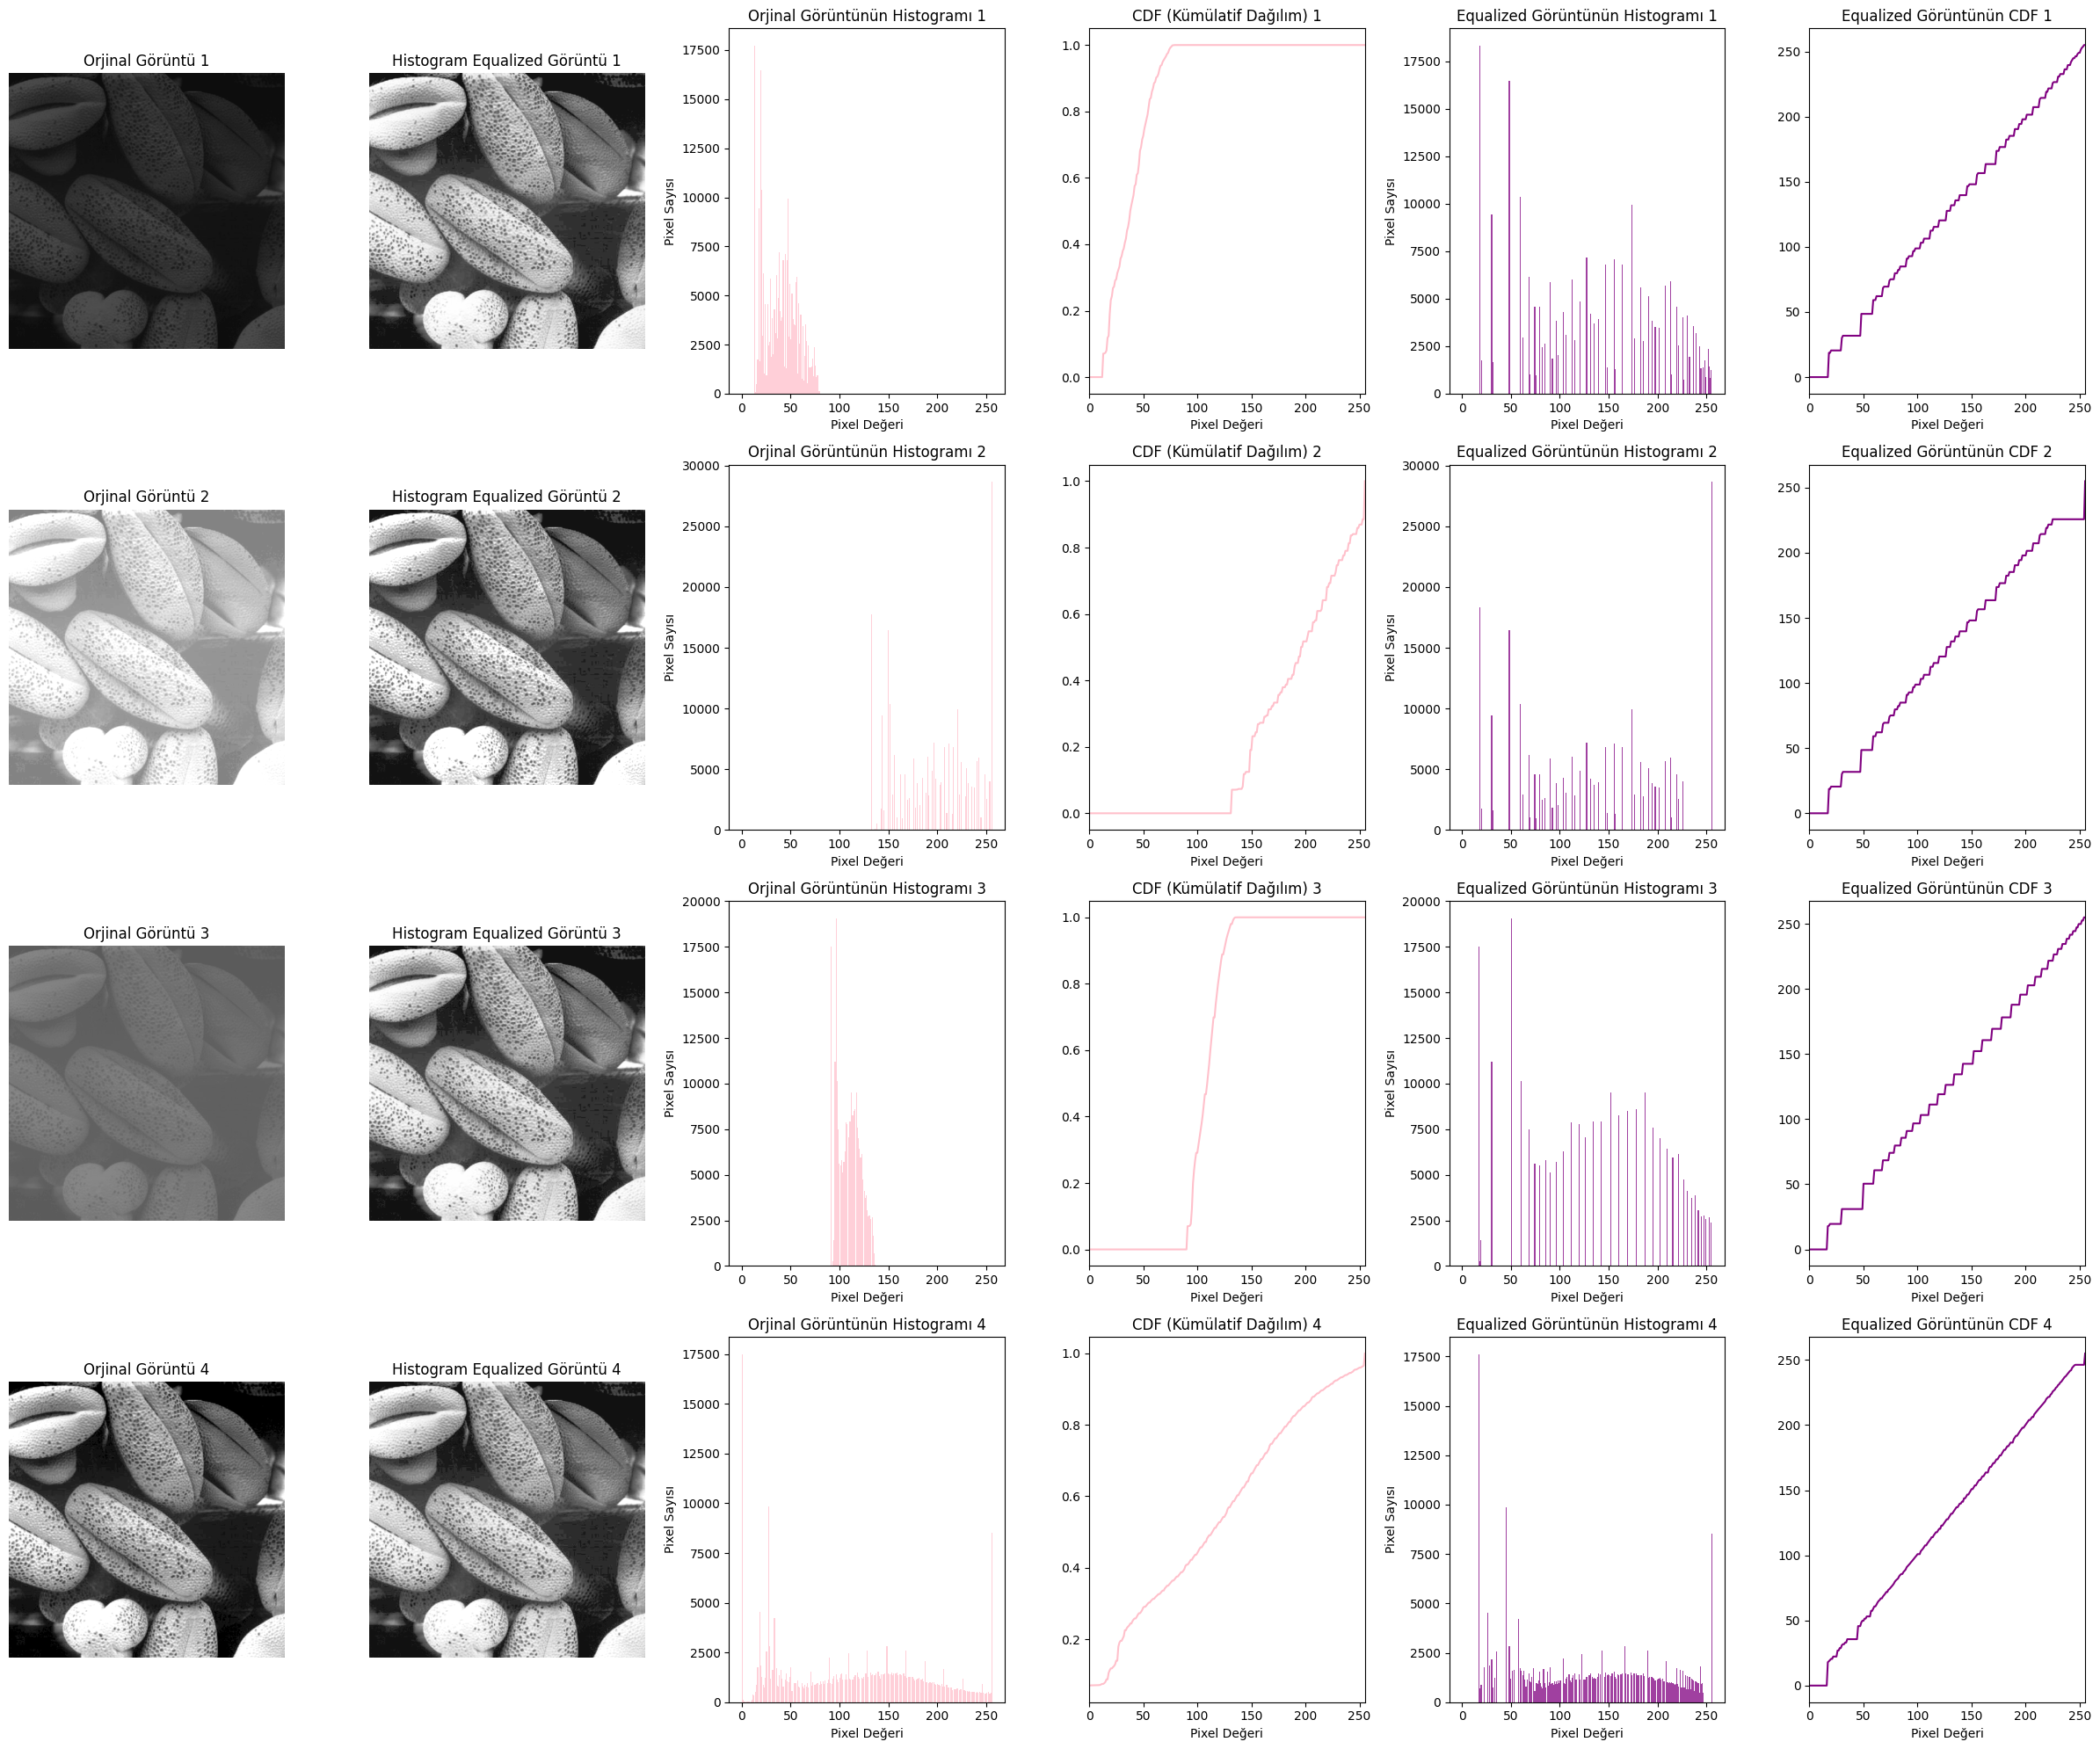

In [13]:
pgm_image_1 = PGMImage('Fig0316(4)(bottom_left).pgm')
pgm_image_2 = PGMImage('Fig0316(1)(top_left).pgm')
pgm_image_3 = PGMImage('Fig0316(2)(2nd_from_top).pgm')
pgm_image_4 = PGMImage('Fig0316(3)(third_from_top).pgm')

plt.figure(figsize=(24, 20))

# Kolay bir şekilde plot edebilmek için yapılmıştır
images = [pgm_image_1, pgm_image_2, pgm_image_3, pgm_image_4]
titles = ['Image 1', 'Image 2', 'Image 3', 'Image 4']

for i, pgm_image in enumerate(images):
    # Orijinal görüntüyü 2D matrise dönüştür
    original_image = np.array(pgm_image.pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width))
    
    # Histogram eşitleme fonksiyonu uygulanır hem görüntü hem de CDF elde edilir
    equalized_pixels, cdf = pgm_image.myHistogramEqualization()
    equalized_image = np.array(equalized_pixels, dtype=np.uint8).reshape((pgm_image.height, pgm_image.width)) # 2D'ye dönüştürülür

    # Orijinal görüntü
    plt.subplot(4, 6, i * 6 + 1)
    plt.title(f'Orjinal Görüntü {i + 1}')
    plt.axis('off')
    plt.imshow(original_image, cmap='gray', vmin=0, vmax=255)

    # Histogram eşitlenmiş görüntü
    plt.subplot(4, 6, i * 6 + 2)
    plt.title(f'Histogram Equalized Görüntü {i + 1}')
    plt.axis('off')
    plt.imshow(equalized_image, cmap='gray', vmin=0, vmax=255)

    # Orijinal görüntünün histogramı
    plt.subplot(4, 6, i * 6 + 3)
    plt.hist(original_image.ravel(), bins=256, range=[0, 256], color='pink', alpha=0.75)
    plt.title(f'Orjinal Görüntünün Histogramı {i + 1}')
    plt.xlabel('Pixel Değeri')
    plt.ylabel('Pixel Sayısı')

    # Orijinal görüntünün CDF'si
    plt.subplot(4, 6, i * 6 + 4)
    plt.plot(cdf, color='pink')
    plt.title(f'CDF (Kümülatif Dağılım) {i + 1}')
    plt.xlabel('Pixel Değeri')
    plt.xlim([0, 255])

    # Histogram eşitlenmiş görüntünün histogramı
    plt.subplot(4, 6, i * 6 + 5)
    plt.hist(equalized_image.ravel(), bins=256, range=[0, 256], color='purple', alpha=0.75)
    plt.title(f'Equalized Görüntünün Histogramı {i + 1}')
    plt.xlabel('Pixel Değeri')
    plt.ylabel('Pixel Sayısı')

    # Histogram eşitlenmiş görüntünün CDF'si
    equalized_hist, _ = np.histogram(equalized_image.ravel(), 256, [0, 256])
    equalized_cdf = np.cumsum(equalized_hist).astype(np.float32)
    equalized_cdf_normalized = equalized_cdf / equalized_cdf[-1] 

    plt.subplot(4, 6, i * 6 + 6)
    plt.plot(equalized_cdf_normalized * 255, color='purple')
    plt.title(f'Equalized Görüntünün CDF {i + 1}')
    plt.xlabel('Pixel Değeri')
    plt.xlim([0, 255])

plt.tight_layout()
plt.show()
